# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [1]:
# Load pickled data
import tensorflow as tf
import pickle
import numpy as np
from PIL import Image
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import resample
from tqdm import tqdm
from tensorflow.contrib.layers import flatten
import matplotlib.pyplot as plt
import csv
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
%matplotlib inline

# TODO: fill this in based on where you saved the training and testing data
training_file = 'train.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']


In [2]:
### To start off let's do a basic data summary.

# TODO: number of training examples
n_train = X_train.shape[0]

# TODO: number of testing examples
n_test = X_test.shape[0]

# TODO: what's the shape of an image?
image_shape = X_train.shape

# TODO: how many classes are in the dataset
n_classes = np.unique(y_test).size

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (39209, 32, 32, 3)
Number of classes = 43


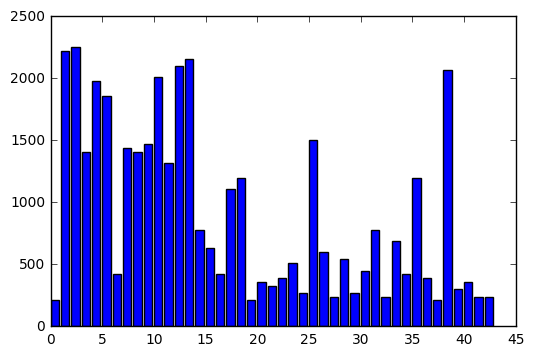

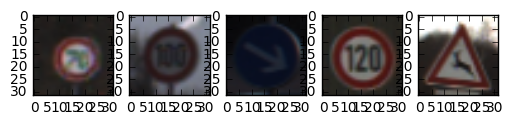

In [3]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
# plot 5 random signs
import random
#for i in range(1,6):
 #   plt.subplot(150 + i)
#plt.imshow(X_train[int(n_train*random.random())])
#plt.imshow(X_train[0])

#plot bar graph for count of each sign type in training set
class_count = np.zeros(n_classes)
for c in y_train:
    class_count[c] = class_count[c] + 1
plt.bar(range(n_classes),class_count)
plt.show()

for i in range(1,6):
    plt.subplot(150 + i)
    plt.imshow(X_train[int(n_train*random.random())])
   

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [4]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.
#rgb to grayscale

def rgb_to_gray(array):
    fs = []
    for i in range(0,array.shape[0]):
        image = array[i]
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        fs.append(gray_image)    
    return np.array(fs)


X_train = rgb_to_gray(X_train)
X_test = rgb_to_gray(X_test)

def flatten_gray(array):
    fs = []
    for i in range(0,array.shape[0]):
        image = array[i]
        f = np.array(image, dtype=np.float32).flatten()
        fs.append(f)
    return np.array(fs) 
    
X_train = flatten_gray(X_train)
X_test = flatten_gray(X_test)

def normalize_greyscale(image_data):
    alpha= 0.1
    beta= 0.9
    min = 0
    max =255
    #value = 0.1 + ((image_data- min)*(b-a))/(max-min)
    greyscale_min = 0
    greyscale_max = 255
    return alpha + ( ( (image_data - greyscale_min)*(beta - alpha) )/( greyscale_max - greyscale_min ) )

X_train = normalize_greyscale(X_train)
X_test = normalize_greyscale(X_test)


# Turn labels into numbers and apply One-Hot Encoding
encoder = LabelBinarizer()
encoder.fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

# Change to float32, so it can be multiplied against the features in TensorFlow, which are float32
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)
    

print('Labels One-Hot Encoded')

Labels One-Hot Encoded


### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**

1. Data converted to grayscale as sign type should be (mostly) invariant to color
2. Data pixel values were normalized using min-max scaling to values between 0.1 - 0.9
3. Labels were 1-hot encoded

### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**
The training and validation sets were generated from the data in the provided train.p dataset. The training set is a random 95% of that dataset, while the validation set is the remaining random 5%. I chose to use 5% of the data for the validation set as that was the percentage that we used in the lab at the end of lesson 8. I am using the provided test.p dataset as the testing data. The training data was then passed to the optimizer and use the validation data to track the progress of the optimizer and tune the various hyperparameters. After I am done optimizing the model, I use the test data to get a sense of how the model will perform in the real world.


In [5]:

# Get randomized datasets for training and validation
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train,
    y_train,
    test_size=0.05,
    random_state=832289)


print('Training features and labels randomized and split.')



Training features and labels randomized and split.


### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer: **

My final network architecture takes batches of 32x32 greyscale images as input and sends those through 2 5x5 convolutional layers with depths of 32 and 64, followed by 2 fully connected layer with a width of 1024. Each of the convolutional layers is followed by a 2x2 max pooling layer. The output layer consisits of a 43-class classifier.

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

Optimizer is AdamOptimizer

Batch Size : 64

Epochs : 10

Learning rate: 0.001 (default for AdamOptimizer)

I tried different optimizer such as AdamOptimier and GradientDescentOptimizer. The AdamOptimizer tends to work better than GradientDescentOptimizer.  Having more epochs thtat are greater than 10 doesnot seem to have significant impact on the accuracy. I also tried different batch size.  Having bigger batch size seems to lower the accuracy.  Having smaller batch size tends to take longer time to train.  So finally I settled using AdamOptimizer as Optimier, batch size is 64 and 10 epochs. 

In [6]:
### Train your model here.
### Feel free to use as many code cells as needed.

def convNet(x):
    
    x_image = tf.reshape(x, [-1,32,32,1])
    conv1_w=tf.Variable(tf.truncated_normal(shape=(5,5,1,32), stddev=0.05))
    conv1_b=tf.Variable(tf.zeros(32))
    conv1 = tf.nn.conv2d(x_image,conv1_w, strides=[1,1,1,1], padding='SAME') +conv1_b
    conv1 = tf.nn.relu(conv1)
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    conv2_w = tf.Variable(tf.truncated_normal(shape=(5, 5, 32, 64), stddev=0.05))
    conv2_b = tf.Variable(tf.zeros(64))
    conv2 = tf.nn.conv2d(conv1, conv2_w, strides=[1, 1, 1, 1], padding='SAME') + conv2_b
    conv2 = tf.nn.relu(conv2)
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    fc1 = flatten (conv2)
    fc1_shape = (fc1.get_shape().as_list()[-1], 1024)
  
   
    fc1_W = tf.Variable(tf.truncated_normal(shape=fc1_shape, stddev=0.05))
    fc1_b = tf.Variable(tf.zeros(1024))
    fc1 = tf.matmul(fc1, fc1_W) + fc1_b
    fc1 = tf.nn.relu(fc1)
    
    fc2_W = tf.Variable(tf.truncated_normal(shape=(1024, 43)))
    fc2_b = tf.Variable(tf.zeros(43))
    return tf.matmul(fc1, fc2_W) + fc2_b





In [7]:
x=tf.placeholder(tf.float32, shape=[None, 1024])
y=tf.placeholder(tf.float32,shape=[None,43])

logits=convNet(x)
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, y))
opt = tf.train.AdamOptimizer()
train_op = opt.minimize(cost)
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy= tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


training_epochs = 10
total_samples = X_train.shape[0]
batch_size =64

# Initializing the variables
init = tf.initialize_all_variables()

#Save the model after training
saver = tf.train.Saver()

# Launch the graph
with tf.Session() as sess:
    sess.run(init)
    # Training cycle
    for epoch in range(training_epochs):
        total_batch = int(total_samples / batch_size)
        # Loop over all batches
        for i in range(total_batch):
            batch_start = i*batch_size
            batch_x = X_train[batch_start:(batch_start + batch_size)]
            batch_y= y_train[batch_start:(batch_start + batch_size)] 
            
            
            # Run optimization op (backprop) and cost op (to get loss value)
            sess.run(train_op, feed_dict={x: batch_x, y: batch_y})
            
        #print("valid accuracy %g"%accuracy.eval(feed_dict={x: X_valid, y: y_valid}))
                           
        # Display logs per epoch step
        c = sess.run(cost, feed_dict={x: batch_x, y: batch_y})
        val = sess.run(accuracy, feed_dict={x: X_valid, y: y_valid})
        print("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(c), " Validation accuracy=","{:.9f}".format(val) )
        
    print("Optimization Finished!")
    save_path = saver.save(sess, "trained.ckpt")

    # Test model
    print(
        "Accuracy:",
        accuracy.eval(feed_dict={x: X_test, y: y_test}))




Epoch: 0001 cost= 0.235672325  Validation accuracy= 0.952065289
Epoch: 0002 cost= 0.053999562  Validation accuracy= 0.983681798
Epoch: 0003 cost= 0.019535409  Validation accuracy= 0.987251401
Epoch: 0004 cost= 0.012773518  Validation accuracy= 0.983681798
Epoch: 0005 cost= 0.034627143  Validation accuracy= 0.978582382
Epoch: 0006 cost= 0.010979673  Validation accuracy= 0.989291191
Epoch: 0007 cost= 0.013374669  Validation accuracy= 0.980112195
Epoch: 0008 cost= 0.011691550  Validation accuracy= 0.983171880
Epoch: 0009 cost= 0.019775847  Validation accuracy= 0.982151985
Epoch: 0010 cost= 0.006708335  Validation accuracy= 0.976032615
Optimization Finished!
Accuracy: 0.924545


### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**

First, I tried implementing the best performing architecture in the referenced "Traffic Sign Recognition with Multi-Scale Convolutional Networks" paper. However, I had lots of issues attaining the expected accuracy. The I used lenet.py (LeNet Architecture) and lab.py as the reference in the course and modified for this project and that seems to work pretty well.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

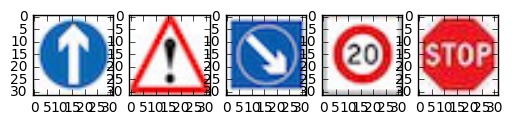

In [21]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
%matplotlib inline

my_images = os.listdir("newimage/")
num_images = len(my_images)
i = 0
my_test = []
for image_file in my_images:
    i = i + 1
    plt.subplot(100 + 10*num_images + i)
    image = mpimg.imread('newimage/' + image_file)
    my_test.append(image)
    plt.imshow(image)
my_test = np.array(my_test)
my_test = normalize_greyscale(flatten_gray(rgb_to_gray(my_test)))


### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._




**Answer:**

The candidate images that I used are taken from the internet. They are very clear and complete pictures. If the image is cropped or has different pattern, it will make classification difficult.

In [23]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

with tf.Session() as sess:
        saver.restore(sess, save_path)
        for i in range (0,5):
            #print ((np.expand_dims(my_test[i],axis=0)).shape)
            prediction = sess.run(tf.argmax(logits, 1), feed_dict={x:np.expand_dims(my_test[i],axis=0)})
            print("image ", i, "predicted class: ", prediction)
        
       

image  0 predicted class:  [35]
image  1 predicted class:  [18]
image  2 predicted class:  [38]
image  3 predicted class:  [0]
image  4 predicted class:  [14]


### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:**

My model correctly classified all 5 new signs of captured images.  From the prediction I did to the candidate image, the testing accurary is nearly perfect.  This is because those candidate images I took from the internet are very nice clear and complete pictures, almost identifical to the ones in the training set.  If the candidate images are cropped or has different pattern than the tranining set, then the accuracy will not be as perfect as this one.

top k classes:  TopKV2(values=array([[  1.00000000e+00,   2.30552543e-14,   2.55857915e-17,
          7.09289425e-18,   4.49758617e-21]], dtype=float32), indices=array([[35,  9, 13, 12,  6]], dtype=int32))


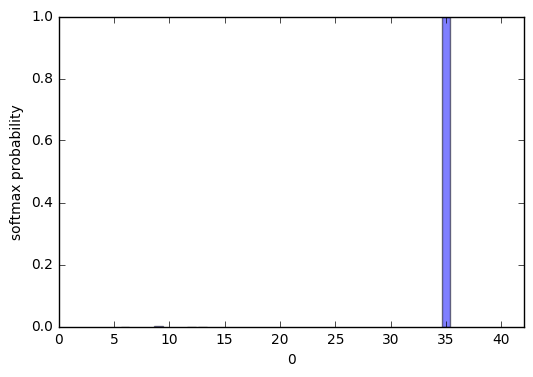

top k classes:  TopKV2(values=array([[  1.00000000e+00,   1.33973263e-13,   3.35995736e-17,
          6.02300537e-21,   2.22639862e-21]], dtype=float32), indices=array([[18, 26, 27, 11, 24]], dtype=int32))


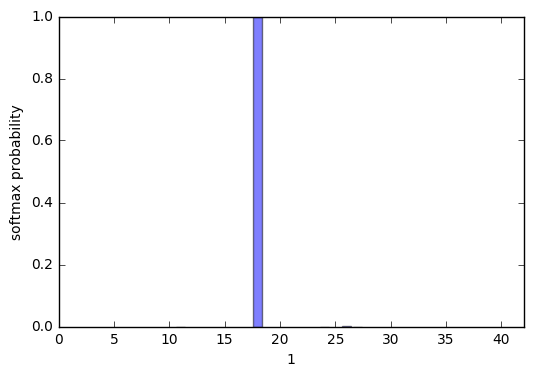

top k classes:  TopKV2(values=array([[  1.00000000e+00,   7.02228740e-30,   5.04826581e-31,
          3.05456179e-34,   2.87996661e-35]], dtype=float32), indices=array([[38, 36, 20, 32, 25]], dtype=int32))


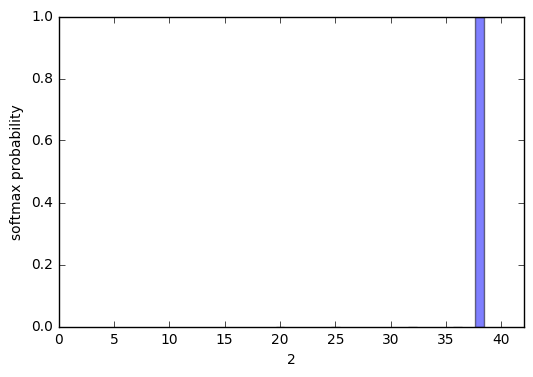

top k classes:  TopKV2(values=array([[  9.99996901e-01,   3.04677542e-06,   1.03908455e-08,
          1.29896538e-09,   1.48886337e-11]], dtype=float32), indices=array([[ 0,  8,  5,  1, 37]], dtype=int32))


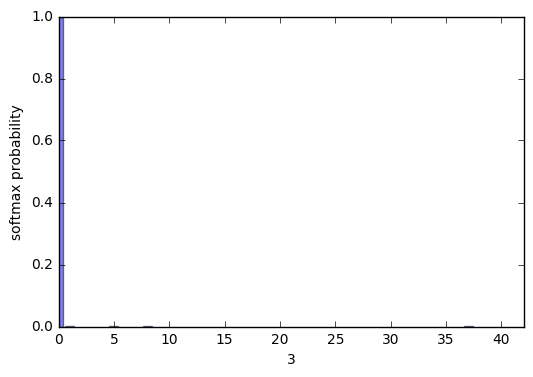

top k classes:  TopKV2(values=array([[  9.99999404e-01,   5.39518282e-07,   1.05206777e-08,
          1.55170532e-09,   9.31251798e-10]], dtype=float32), indices=array([[14,  3, 18,  9,  4]], dtype=int32))


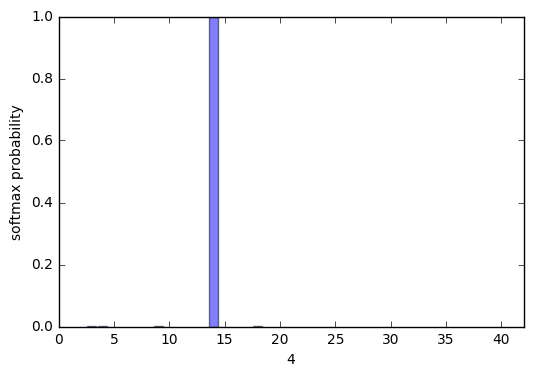

In [24]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

with tf.Session() as sess:
    saver.restore(sess, save_path)
    for i in range (0,5):
            #print ((np.expand_dims(my_test[i],axis=0)).shape)
            top_k= sess.run(tf.nn.top_k(tf.nn.softmax(logits),k=5), feed_dict={x:np.expand_dims(my_test[i],axis=0)})
            
            print("top k classes: ", top_k)
            #print(top_k.indices.flatten().tolist(), top_k.values.flatten().tolist())            
            plt.bar (top_k.indices.flatten().tolist(),top_k.values.flatten().tolist(), align='center', alpha=0.5)
            plt.xlim(0,42)
            plt.ylabel('softmax probability')
            plt.xlabel(i)
            plt.show()
    

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**

The model works very well for all the 5 signs. For signs 1,2,3, the model is very certian on the predictions (100%).  For sign 4 and 5, it is near 100% certain.

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.